This code uses PyPortfolioOpt to optmise a stock portfolio given price data 

Sources:

Youtube link: [Build A Killer Stock Portfolio Using Python](https://www.youtube.com/watch?v=bvDkel5whUY&ab_channel=ComputerScience)

Article :     [Portfolio Optimization through mean-variance analysis](https://www.machinelearningplus.com/machine-learning/portfolio-optimization-python-example/)

## To Do: 
- <span style="color:green">**Add drop the last days data and reload when updating dbs**
    - DONE: now before saving the updated DB I drop the last row of incomplete data </span>
- <span style="color:green"> **DONE: Drop any columns which have nulls in the last row** </span>
- Add intro and example on subset of the data
- drop any columns which have nulls in the last row
-  try efficient frontier on small set (done need to add for visual)
- width has an effect of speed is removing negative returns a good tactic to reduce size
- something is breaking the pyportfolio opt i think its either size or nulls 
    - it was NULLS , solved by checking the last rows for NULL ie delisted shares
- Update list of active stock tickers 
    - have TSVs need to save as CSV to use
- Remove any stocks with high prices (as i cant afford to buy those)


In [14]:
#Import the libraries
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import math
from datetime import timedelta 
import operator
from functools import reduce
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import cvxpy as cp
from joblib import Parallel, delayed
import seaborn as sns
pd.set_option('display.max_columns', 38)


In [15]:
# Define the ticker list from saved files of company info
df_NYSE_info=pd.read_csv("Company lists/companylist_NYSE.tsv",sep='\t') #We have the lists saved as TSV ie delimited wth tabs rather than commas
df_Nasdaq_info=pd.read_csv("Company lists/companylist_NASDAQ.tsv",sep='\t')
l_NYSE=df_NYSE_info.Symbol.tolist()
l_Nasdaq=df_Nasdaq_info.Symbol.tolist()

[*********************100%***********************]  1 of 1 completed


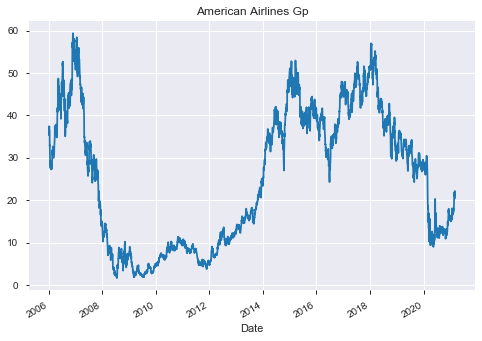

In [16]:
#Quick test to ensure yfinance is working(goes down sometimes)
# Fetch the data
data = yf.download('AAL','2006-1-1')['Adj Close']

# Plot the close price of the AAPL
data.plot(title=df_Nasdaq_info.loc[df_Nasdaq_info['Symbol']=='AAL', 'Description'].iloc[0])
plt.show()

## Defining Database & data fetching functions 

In [30]:
DATE_FORMAT = '%Y-%m-%d'

# Data base maintainance functions

#Connects to a the pre-existing CSV price database
def connectAndLoadDb(exchange):
    print("Connecting database:"+str(exchange))
    filename='Price Databases\database_'+str(exchange)+'.csv'
    database = pd.read_csv(filename,index_col=False) 
    print("Database connected!")
    return database;

#Gets the latest date of data in the db
def getLastEntryDate(database):
    lastDateEntry = database.iloc[-1]['Date']
    lastDateEntry = datetime.datetime.strptime(lastDateEntry, DATE_FORMAT)    
    return lastDateEntry

#Writes the updated pandas dataframe to the CSV
def writeDbToExcelFile(database,exchange):
    filename='Price Databases\database_'+str(exchange)+'.csv'
    print('Writing database to filename: '+ filename)
    database.index=database['Date']
    database.drop(['Date'],axis=1,inplace=True)
    database.to_csv(filename)
    print('Database updated with new entries!!')

#Formats the date from number for printing      
def prettyPrintDate(date):
    return date.strftime(DATE_FORMAT);

#Data Fetching functions

#get ticker list from our tsv files
def getTickers(exchange):
    #We have the lists saved as TSV ie delimited wth tabs rather than commas
    df_info=pd.read_csv('Company lists/companylist_'+str(exchange)+'.tsv',sep='\t') 
    l_tickers=df_info.Symbol.tolist()
    return l_tickers;

#Pulls adj closing price data from yfinance for a given list of stock tickers 'l_tickers', for all dates up to today from a given 'date' merges this data with an existing database 'database'
def fetchAndAppendToDb(date, database, exchange):  
    dateStr = prettyPrintDate(date)
    print('Fetching stock closing price of '+str(exchange)+' for days over: ' + dateStr)

    l_tickers=getTickers(exchange)
    #Pulling adj closing price data from yfinance
    mergedData = yf.download(l_tickers,date)['Adj Close']

    #Making date the index col
    mergedData['Date']=mergedData.index

    #append our new data onto the existing databae
    database = database.append(mergedData, ignore_index=True)
    return database;


def fetchData(database,exchange, refetchAll = False):
    if refetchAll == True:
        lastEntryDate = datetime.datetime.strptime('2006-01-01', DATE_FORMAT) #Start date here 
    else:
        lastEntryDate = getLastEntryDate(database)
    ydaysDate = datetime.datetime.today() - timedelta(days = 1)
    if lastEntryDate >= ydaysDate:
        print('Data already loaded up to Yesterday')
        return database
    else:
        print("Last entry in Db is of :" + prettyPrintDate(lastEntryDate))
        print("----------------------------------------------")
    
        dateToFetch = lastEntryDate + timedelta(days=1)

        database = fetchAndAppendToDb(dateToFetch, database, exchange)
    
        print("----------------------------------------------")
        print("Data fill completed! 👍👍")
        return database;

## Update Nasdaq data

In [36]:
%%time
#run this lines for a fresh run
database = pd.DataFrame()
database = fetchData(database,'NASDAQ', refetchAll = True)


# run these lines to update an existing database
#database = connectAndLoadDb('NASDAQ')
#database = fetchData(database,'NASDAQ')

database.tail()

Last entry in Db is of :2006-01-01
----------------------------------------------
Fetching stock closing price of NASDAQ for days over: 2006-01-02
[*********************100%***********************]  4227 of 4227 completed
----------------------------------------------
Data fill completed! 👍👍
Wall time: 15min 39s


,AACG,AACQ,AACQU,AACQW,AAL,AAME,AAOI,AAON,AAPL,AAWW,AAXJ,ABCB,ABCL,ABCM,ABEO,ABGI,ABIO,ABMD,ABNB,...,ZIONP,ZIOP,ZIXI,ZKIN,ZLAB,ZM,ZNGA,ZNTE,ZNTEU,ZNTEW,ZNTL,ZS,ZSAN,ZUMZ,ZVO,ZWRKU,ZYNE,ZYXI,Date
3818,5.15,11.23,12.01,NaN,21.180000,4.76,9.020,77.379997,127.790001,55.320000,97.339996,49.020000,39.689999,22.590000,2.34,10.25,4.37,324.260010,196.419998,...,24.832500,5.26,7.42,7.44,162.020004,409.660004,11.56,10.96,12.14,2.71,41.730000,210.160004,1.33,47.060001,5.19,10.330,4.66,14.69,2021-03-01
3819,5.07,10.73,11.51,NaN,21.440001,4.70,8.625,74.919998,125.120003,56.570000,95.930000,48.970001,38.000000,22.920000,2.36,10.14,4.52,325.309998,189.899994,...,24.910000,5.07,7.35,6.40,148.009995,372.790009,11.39,10.57,11.55,2.40,43.500000,202.610001,1.25,46.540001,5.29,10.150,4.68,14.25,2021-03-02
3820,4.63,10.38,11.03,NaN,22.170000,4.43,8.360,74.089996,122.059998,57.189999,95.620003,50.160000,35.669998,22.209999,2.19,10.09,4.27,307.600006,180.399994,...,24.934999,4.68,6.97,6.29,140.669998,341.570007,11.09,10.35,11.06,1.83,43.630001,187.830002,1.22,46.330002,5.09,10.025,4.51,14.25,2021-03-03
3821,4.26,10.29,10.79,NaN,21.240000,3.65,7.990,72.070000,120.129997,55.139999,93.389999,49.860001,30.049999,21.129999,2.08,9.99,3.98,295.630005,180.229996,...,25.110001,4.31,7.13,5.20,133.070007,343.089996,10.48,10.20,10.95,1.51,43.549999,180.899994,1.07,45.389999,4.61,10.000,4.09,14.54,2021-03-04
3822,4.08,10.66,11.34,1.91,20.450001,3.67,8.045,72.800003,121.419998,57.650002,94.459999,50.349998,28.610001,21.110001,2.01,9.97,4.12,301.220001,179.809998,...,24.760000,4.29,7.15,5.18,137.250000,337.429993,10.31,10.36,11.19,1.85,42.330002,175.369995,1.07,46.029999,4.72,10.200,4.15,14.75,2021-03-05


In [37]:
%%time
# Drop the last entry prior to saving as it probably is not a full days data
database.drop(database.tail(1).index, inplace = True) 

# Write the data to CSV
writeDbToExcelFile(database,'Nasdaq')

Writing database to filename: Price Databases\database_Nasdaq.csv
Database updated with new entries!!
Wall time: 24 s


## Update NYSE data

In [38]:
%%time
#run this lines for a fresh run
database = pd.DataFrame()
database = fetchData(database,'NYSE', refetchAll = True)


# run these lines to update an existing database
#database = connectAndLoadDb('NYSE')
#database = fetchData(database,'NYSE')

database.tail()

 SWB.U: No data found, symbol may be delisted
- BSN.U: No data found, symbol may be delisted
- FVT.W: No data found, symbol may be delisted
- NS-A: No data found, symbol may be delisted
- CND.U: No data found, symbol may be delisted
- PEI-C: No data found, symbol may be delisted
- HZA.U: No data found, symbol may be delisted
- PSB-X: No data found, symbol may be delisted
- OAC.Z: No data found, symbol may be delisted
- PSA-H: No data found, symbol may be delisted
- ALU.U: No data found, symbol may be delisted
- AHL-D: No data found, symbol may be delisted
- CIT-B: No data found, symbol may be delisted
- CAS.U: No data found, symbol may be delisted
- FST.U: No data found, symbol may be delisted
- CIM-C: No data found, symbol may be delisted
- PSA-G: No data found, symbol may be delisted
- CHA.U: No data found, symbol may be delisted
- EPR-G: No data found, symbol may be delisted
- HIG-G: No data found, symbol may be delisted
- TNP-F: No data found, symbol may be delisted
- SCV.U: No dat

,A,AA,AAC.U,AAI-B,AAI-C,AAIC,AAN,AAP,AAT,AB,ABB,ABBV,ABC,ABEV,ABG,ABM,ABR,ABR-A,ABR-B,...,YELP,YETI,YEXT,YPF,YRD,YSG,YUM,YUMC,ZBH,ZEN,ZEPP,ZIM,ZNH,ZTO,ZTR,ZTS,ZUO,ZYME,Date
3825,124.480003,25.99,NaN,NaN,NaN,4.06,22.219999,162.660004,31.980000,37.299999,29.280001,108.410004,103.169998,2.50,172.149994,44.029999,16.540001,NaN,NaN,...,37.970001,71.169998,18.010000,4.16,5.22,18.690001,104.510002,59.720001,163.399994,150.539993,17.330000,20.209999,34.560001,35.220001,8.99,157.690002,15.50,36.770000,2021-03-01
3826,123.639999,27.50,NaN,NaN,NaN,4.08,21.760000,164.839996,32.410000,37.529999,29.770000,107.849998,104.250000,2.52,167.699997,43.330002,16.680000,NaN,NaN,...,37.139999,69.760002,17.719999,3.96,4.97,19.290001,104.739998,59.310001,161.190002,148.770004,16.620001,20.459999,33.689999,35.060001,9.02,157.050003,15.29,36.610001,2021-03-02
3827,119.300003,30.83,NaN,NaN,NaN,4.01,22.129999,165.830002,33.900002,37.790001,29.420000,106.709999,103.339996,2.55,166.940002,44.500000,16.370001,NaN,NaN,...,37.529999,69.339996,16.549999,3.99,4.85,18.400000,103.510002,59.610001,159.750000,142.500000,15.510000,21.000000,35.380001,34.799999,9.12,149.320007,15.00,34.160000,2021-03-03
3828,114.989998,28.59,NaN,NaN,NaN,4.01,23.100000,165.539993,33.820000,36.459999,29.170000,105.650002,102.989998,2.66,167.919998,44.439999,15.920000,NaN,NaN,...,37.340000,65.089996,14.570000,4.19,4.46,17.760000,103.570000,59.180000,156.250000,136.130005,14.250000,20.230000,35.299999,34.480000,8.99,144.000000,14.35,31.940001,2021-03-04
3829,116.139999,28.99,NaN,NaN,NaN,4.14,23.959999,171.509995,34.599998,37.389999,29.700001,106.699997,104.830002,2.71,171.649994,46.220001,15.680000,NaN,NaN,...,39.279999,65.629997,15.220000,4.25,4.39,17.799999,104.330002,60.419998,158.500000,133.080002,14.320000,19.299999,33.930000,34.959999,9.14,145.679993,13.65,32.939999,2021-03-05


In [39]:
%%time
# Drop the last entry prior to saving as it probably is not a full days data
database.drop(database.tail(1).index, inplace = True) 

writeDbToExcelFile(database,'NYSE')

Writing database to filename: Price Databases\database_NYSE.csv
Database updated with new entries!!
Wall time: 34.8 s


# [Portfolio Optimization through mean-variance analysis](https://www.machinelearningplus.com/machine-learning/portfolio-optimization-python-example/)

## 1. What is portfolio optimization?
Portfolio optimization is the process of creating a portfolio of assets, for which your investment has the maximum return and minimum risk.

## 2. What does a portfolio mean?
An investor’s portfolio basically is his/her investment in different kinds of assets from different companies.

For example, if you have investments in 3 companies, say, Google, Amazon and Tesla, then these 3 companies make up your investment portfolio.

But how do you invest in a company? You do so by purchasing assets of that company.

## 3. What are assets, returns and risk?
Assets are of various kinds. An asset is what you would purchase if you want to invest in a company.

These include, but are not limited to:
- Bonds
- Stocks
- Cash
- Real Estate
Usually when you build a portfolio, it is advisable to diversify your assets, or purchase different kinds of assets from different companies. For all assets, you will get a profit after a specified period of time. However, the profit may not be the same for each investment you make.

This profit is what we call returns.

For example, you will get returns from stocks when it’s market value goes up and similarly you will get returns from cash in form of interest.

But what if the company whose stocks you have purchased goes bankrupt?

This will lead to its stocks crashing in the share market and instead of gaining profits, you will also lose your capital investment.

This is what is called risk of investment.

Another aspect of risk is the fluctuations in the asset value. For certain assets, its value is highly volatile, that is, the value increases when the market goes up, and drops accordingly. Whereas certain other assets, like bonds and certain steady stocks, are relatively more resistant to market conditions, but may give lesser returns compared to high risk ones.

A good portfolio is one which gives us maximum return on our investment for minimum risk, as discussed earlier.

The next question is, how do we decide out of an infinite possible combinations for portfolios, the one which is optimum?

## 4. Modern Portfolio Theory (MPT)
Modern Portfolio Theory, or also known as mean-variance analysis is a mathematical process which allows the user to maximize returns for a given risk level.

It was formulated by H. Markowitz and while it is not the only optimization technique known, it is the most widely used.

MPT assumes that all investors are risk-averse, i.e, if there is a choice between low risk and high risk portfolios with the same returns, an investor will choose one with the low risk.

So, what is the MPT all about?

MPT encourages diversification of assets. It says that a high variance asset A if combined with diverse assets B and C, where A, B and C have little to no correlation, can give us a portfolio with low variance on returns.

This is the crux of the Modern Portfolio Theory.

## 5. What is Efficient Frontier?
We know every asset in a portfolio has its own rate expected returns and risks. It is possible to create multiple combinations of assets that can provide high returns for a pre-defined risk level.

Likewise, there can be multiple portfolios that give lowest risk for a pre-defined expected return.

Efficient frontier is a graph with ‘returns’ on the Y-axis and ‘volatility’ on the X-axis. It shows the set of optimal portfolios that offer the highest expected return for a given risk level or the lowest risk for a given level of expected return.

Portfolios that lie outside the efficient frontier are sub-optimal because they do not provide either enough return for the level of risk or have a higher risk for the defined rate of return.

We will revisit this with an example again.

Now that you understand the term of portfolio optimization, let’s see how its actually implemented.

## 6. Fundamental terms in portfolio optimization
There are some statistical terms required in optimization process without which an optimal portfolio can’t be defined. Don’t worry, I will simplify it and make it easy and clear.

We will go through each one through an example.

In this example, we are considering a portfolio made up of stocks from just 4 companies, Microsoft, Apple, Tesla and Facebook.

### Step 1: Pull the stock price data

We have this data from the data bases earlier in this script, so we can connect to our nasdaq database which has the closing price of company’s stock on the given day and pull this data for these stocks:

In [7]:
%%time
df_Nasdaq=connectAndLoadDb('Nasdaq')

#set dates as index
df_Nasdaq=df_Nasdaq.set_index(pd.DatetimeIndex(df_Nasdaq['Date'].values))
df_Nasdaq.drop(columns=['Date'],axis=1, inplace=True)

#Stock list Tickers we want Microsoft, Apple, Tesla and Facebook
l_stocks=['AAPL', 'MSFT', 'TSLA', 'FB']

df_example=df_Nasdaq[l_stocks]
df_example.tail()

Connecting database:Nasdaq
Database connected!
Wall time: 2.86 s


,AAPL,MSFT,TSLA,FB
2021-02-19,129.869995,240.970001,781.299988,261.559998
2021-02-22,126.000000,234.509995,714.500000,260.329987
2021-02-23,125.860001,233.270004,698.840027,265.859985
2021-02-24,125.349998,234.550003,742.020020,264.309998
2021-02-25,120.989998,228.990005,682.219971,254.690002


## Step 2: Calculate percentage change in stock prices

Next, we calculate the percentage change in stock prices of tesla everyday. You will notice that that we take the log of percentage change.

But take log?  The reason for this is that log of the returns is time additive.

That is, $ log(r_{13}) = log(r_{12}) + log(r_{23}) $

For example:,
If $ p_1 = 100,\quad p_2 = 110,\quad p_3 = 120  $
where $ p_1 $ is price of stock in time 1

Then:

$ log(r_{12}) = ln(\frac{p_2}{p_1}) = ln(\frac{110}{100}) = 9.53%, $

$ log(r_{23}) = ln(\frac{120}{110}) = 8.7% $ and

$ log(r_{13}) = log(r_{12}) + log(r_{23}) = 9.53 + 8.7 = 18.23%, $  which is same as $ ln(\frac{120}{100}) $.

This means a log change of +0.1 today and then -0.1 tomorrow will give you the same value of stock as yesterday. This is not true if you simply compute percentage change.

It is common practice in portfolio optimization to take log of returns for calculations of covariance and correlation.

In [9]:
# Log of percentage change
tesla = df_example['TSLA'].pct_change().apply(lambda x: np.log(1+x))
tesla.tail()

2021-02-19   -0.007752
2021-02-22   -0.089376
2021-02-23   -0.022161
2021-02-24    0.059954
2021-02-25   -0.084024
Name: TSLA, dtype: float64

## Variance
The variance in prices of stocks of Tesla are an important indicator of how volatile this investment will be (how returns can fluctuate).

It can be calculated for each company by using built in .var() function. Under the hood, the formula implemented by this function is given by:
$$ s^2 = \sum_{i=1}^N (x_i – \bar{x})^2 / N-1 $$

In [10]:
# Variance
var_tesla = tesla.var()
var_tesla

0.0012521044172362353

Similarly for Facebook,

In [11]:
# Log of Percentage change for Facebook
fb = df_example['FB'].pct_change().apply(lambda x: np.log(1+x))

# Variance
var_fb = fb.var()
var_fb

0.0005444862248865686

## Volatility
Volatility is measured as the standard deviation of a company’s stock.

If you carefully look at the formula for standard deviation, you will understand that it is just the square root of variance.

$$ s = \sqrt{ \sum_{i=1}^N (x_i – \bar{x})^2 / N-1} $$

But volatility for the annual standard deviation. What we get from square root of variance is the daily standard deviation. To convert it to annual standard deviation we multiply the variance by 250.

250 is used because there are 250 trading days in a year.

In [12]:
# Volatility
tesla_vol = np.sqrt(var_tesla * 250)
fb_vol = np.sqrt(var_fb * 250)
tesla_vol, fb_vol

(0.5594873584890536, 0.3689465492746099)

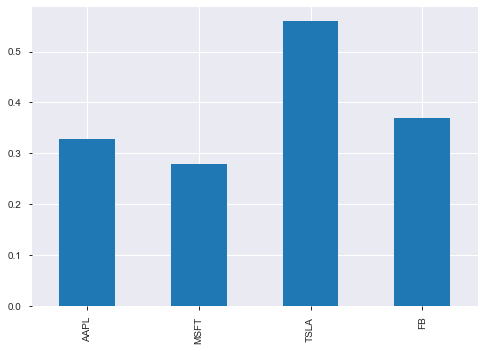

In [13]:
# Volatility of our stocks plotted
df_example.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250)).plot(kind='bar')

## Covariance
Covariance measures the directional relationship between the returns on two assets.

A positive covariance means that returns of the two assets move together while a negative covariance means they move inversely. Risk and volatility can be reduced in a portfolio by pairing assets that have a negative covariance.

We can calculate the covariance of Tesla and Facebook by using the .cov() function.

You can notice that there is small positive covariance between Tesla and Facebook.

In [16]:
# Log of Percentage change
test1 = df_example.pct_change().apply(lambda x: np.log(1+x))
# Covariance
test1['TSLA'].cov(test1['FB'])


0.00021762256279871

## Correlation
Correlation, in the finance and investment industries, is a statistic that measures the degree to which two securities move in relation to each other. Correlations are used in advanced portfolio management, computed as the correlation coefficient, which has a value that must fall between -1.0 and +1.0.

You can think of correlation as a scaled version of covariance, where the values are restricted to lie between -1 and +1.

A correlation of -1 means negative relation, i.e, if correlation between Asset A and Asset B is -1, if Asset A increases, Asset B decreases.

A correlation of +1 means positive relation, i.e, if correlation between Asset A and Asset B is 1, if Asset A increases, Asset B increases.

A correlation of 0 means no relation, i.e, if correlation between Asset A and Asset B is 0, they dont have any effect on each other.

This is calculated using the .corr() function.

In line with the covariance, the correlation between Tesla and Facebook is also positive.

In [18]:
test1['TSLA'].corr(test1['FB'])

0.2670790108707766

## Expected Returns
Expected returns of an asset are simply the mean of percentage change in its stock prices. So, the value of expected return we obtain here are daily expected returns.

For a yearly expected return value, you will need to resample the data year-wise, as you will see further.

For expected returns, you need to define weights for the assets choosen.

In simpler terms, this means you need to decide what percentage of your total money to you want to hold in each company’s stock.

Usually this decision is done by using the optimization techniques we will discuss later but for now we will consider random weights.

First, let’s compute the log of percentage change.

In [20]:
test2 = df_example.pct_change().apply(lambda x: np.log(1+x))
test2.head()

,AAPL,MSFT,TSLA,FB
2006-01-03,NaN,NaN,NaN,NaN
2006-01-04,0.002939,0.004832,NaN,NaN
2006-01-05,-0.007901,0.000741,NaN,NaN
2006-01-06,0.025486,-0.002968,NaN,NaN
2006-01-09,-0.003282,-0.001860,NaN,NaN


## Weights
Let’s define an array of random weights for the purpose of calculation. These weights will represent the percentage allocation of investments between these two stocks. They must add up to 1.

So, the problem of portfolio optimization is nothing but to find the optimal values of weights that maximizes expected returns while minimizing the risk (standard deviation).

In [22]:
# Define weights for allocation
w = [0.2,0.2,0.3, 0.3]
e_r_ind = test2.mean()
e_r_ind

AAPL    0.001041
MSFT    0.000647
TSLA    0.001848
FB      0.000859
dtype: float64

The total expected return for a portfolio is given by:

$$ E(R_p) = w_1E(R_1) + w_2E(R_2) + ….. w_nE(R_n)$$

Thus, $ e_r $, or total expected return can be calculated as:

In [23]:
# Total expected return
e_r = (e_r_ind*w).sum()
e_r

0.0011497937250900703

### 7. Building an optimal risky portfolio
Now that you have gone through the building blocks of portfolio optimization, it is time to create an optimal portfolio using the same concepts.

We will be using stocks from 4 companies, namely, Microsoft, Apple, Tesla and Facebook for a period of 5 years.

You will learn to calculate the weights of assets for each one. Then, we will calculate the expected returns, minimum variance portfolio, optimal risky portfolio and efficient frontier. You will also learn a new term called Sharpe Ratio.

Let’s get started by pulling the required asset data from our database.

In [49]:
%%time
df_Nasdaq=connectAndLoadDb('Nasdaq')

#set dates as index
df_Nasdaq=df_Nasdaq.set_index(pd.DatetimeIndex(df_Nasdaq['Date'].values))
df_Nasdaq.drop(columns=['Date'],axis=1, inplace=True)

#Stock list Tickers we want Microsoft, Apple, Tesla and Facebook
l_stocks=['AAPL', 'MSFT', 'TSLA', 'FB']

df_example=df_Nasdaq[l_stocks]
df_example=df_example['2015-01-01':'2020-01-01']
df_example.tail()

Connecting database:Nasdaq
Database connected!
Wall time: 2.72 s


,AAPL,MSFT,TSLA,FB
2019-12-24,69.973328,155.372406,85.050003,205.119995
2019-12-26,71.361626,156.645950,86.188004,207.789993
2019-12-27,71.334534,156.932251,86.075996,208.100006
2019-12-30,71.757919,155.579727,82.940002,204.410004
2019-12-31,72.282227,155.688324,83.666000,205.250000


## 8. Covariance and Correlation matrix
The first step is to obtain a covariance and correlation matrix to understand how different assets behave with respect to each other. When we had a 2 asset portfolio, we directly plugged in the names of the assets into .cov() and .corr() functions.

In this case, we will need a matrix for better visualisation. This is also achieved by using the same 2 functions on our dataframe df.

Note that we perform necessary operations to display log change in prices of stocks each day.

In [50]:
# Log of percentage change
cov_matrix = df_example.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

,AAPL,MSFT,TSLA,FB
AAPL,0.000246,0.000132,0.000132,0.000129
MSFT,0.000132,0.000215,0.000129,0.000135
TSLA,0.000132,0.000129,0.000798,0.000149
FB,0.000129,0.000135,0.000149,0.000320


The covariance between Apple and Apple, or Tesla and Tesla is the variance of that asset.

The next step is to create the correlation matrix. Correlation ranges from -1 to 1.

Trivialy, an asset always has a perfectly positive correlation of 1 with itself.

In [51]:
corr_matrix = df_example.pct_change().apply(lambda x: np.log(1+x)).corr()
corr_matrix

,AAPL,MSFT,TSLA,FB
AAPL,1.000000,0.575227,0.298753,0.459174
MSFT,0.575227,1.000000,0.312652,0.515825
TSLA,0.298753,0.312652,1.000000,0.294825
FB,0.459174,0.515825,0.294825,1.000000


## Portfolio Variance
The formula for calculating portfolio variance differs from the usual formula of variance. It looks like this:

$$\sigma^2(Rp) = \sum{i=1}^{n} \sum_{j=1}^{n} w_i w_j COV(R_i, R_j) $$
Here, $ w_i $ and $ w_j $ denote weights of all assets from 1 to n (in our case from 1 to 4) and $ COV(R_i, R_j) $ is the covariance of the two assets denoted by i and j.
The simplest way to do this complex calculation is defining a list of weights and multiplying this list horizontally and vertically with our covariance matrix.

For this purpose, let’s define a random list of weights for all 4 assets. Remember that sum of weights should always be 1.

In [52]:
# Randomly weighted portfolio's variance
w = {'AAPL': 0.1, 'MSFT': 0.2, 'TSLA': 0.5, 'FB': 0.2}
port_var = cov_matrix.mul(w, axis=0).mul(w, axis=1).sum().sum()
port_var

0.0003134577081363452

Thus we have found the portfolio variance. But for truly optimizing the portfolio, we cant plug in random weights. We will need to calculate it according to what gives us maximum expected returns.

### 9. Portfolio expected returns
The mean of returns (given by change in prices of asset stock prices) give us the expected returns of that asset.
The sum of all individual expected returns further multiplied by the weight of assets give us expected return for the portfolio.

Note that we use the resample() function to get yearly returns. The argument to function, ‘Y’, denotes yearly.
If we dont perform resampling, we will get daily returns, like you saw earlier in the ‘Fundamental Terms’ section.

In [53]:
# Yearly returns for individual companies
ind_er = df_example.resample('Y').last().pct_change().mean()
ind_er

AAPL    0.361281
MSFT    0.335404
TSLA    0.168312
FB      0.235412
dtype: float64

In [54]:
# Portfolio expected returns
w = [0.1, 0.2, 0.5, 0.2]
port_er = (w*ind_er).sum()
port_er

0.23444760345932286

## Plotting the efficient frontier
This is the aim of going through all the topics above, to plot the efficient frontier. Efficient frontier is a graph with ‘returns’ on the Y-axis and ‘volatility’ on the X-axis. It shows us the maximum return we can get for a set level of volatility, or conversely, the volatility that we need to accept for certain level of returns.

Below, you can see the calculations and code for finding the optimal weights of assets and plotting the efficient frontier for given portfolio.
But first, lets take a look at the volatiltilty and returns of individual assets for a better understanding.

In [55]:
# Volatility is given by the annual standard deviation. We multiply by 250 because there are 250 trading days/year.
ann_sd = df_example.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
ann_sd

AAPL    0.247789
MSFT    0.231661
TSLA    0.446643
FB      0.282744
dtype: float64

In [56]:
assets = pd.concat([ind_er, ann_sd], axis=1) # Creating a table for visualising returns and volatility of assets
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
AAPL,0.361281,0.247789
MSFT,0.335404,0.231661
TSLA,0.168312,0.446643
FB,0.235412,0.282744


Tesla has the maximum risk attached but has low returns. Apple has low risk and high return rates. Facebook is somewhere in the middle.

Next, to plot the graph of efficient frontier, we need run a loop. In each iteration, the loop considers different weights for assets and calculates the return and volatility of that particular portfolio combination.

We run this loop a 10,000 times.

To get random numbers for weights, we use the np.random.random() function. But remember that the sum of weights must be 1, so we divide those weights by their cumulative sum.

In [57]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

num_assets = len(df_example.columns)
num_portfolios = 10000

In [58]:
%%time
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_er) # Returns are the product of individual expected returns of asset and its 
                                      # weights 
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)

Wall time: 25.4 s


In [59]:
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(df_example.columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]
    
portfolios  = pd.DataFrame(data)
portfolios.head() # Dataframe of the 10000 portfolios created    

,Returns,Volatility,AAPL weight,MSFT weight,TSLA weight,FB weight
0,0.275077,0.217329,0.147489,0.329660,0.176796,0.346055
1,0.265020,0.232773,0.142097,0.321298,0.304105,0.232500
2,0.238947,0.293257,0.160916,0.203563,0.552518,0.083003
3,0.243963,0.272102,0.032100,0.361767,0.471887,0.134246
4,0.291139,0.215732,0.145873,0.385006,0.016860,0.452261


You can see that there are a number of portfolios with different weights, returns and volatility. Plotting the returns and volatility from this dataframe will give us the efficient frontier for our portfolio.

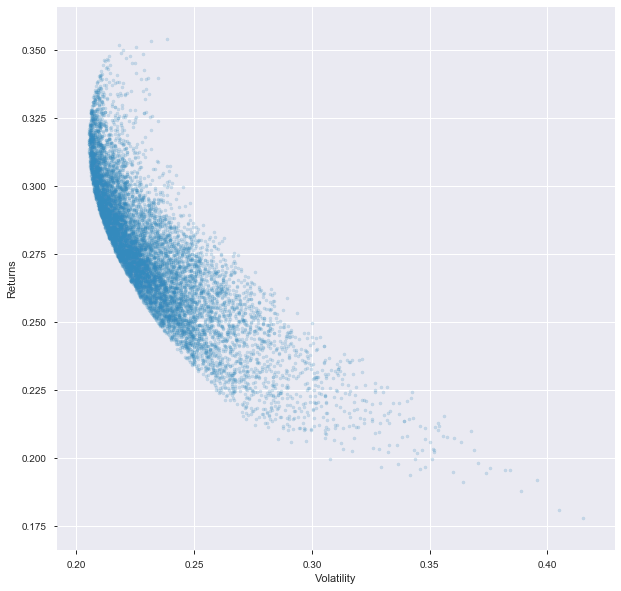

In [60]:
# Plot efficient frontier
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.2, grid=True, figsize=[10,10])

### How to read the Efficient Frontier?
Each point on the line (left edge) represents an optimal portfolio of stocks that maximises the returns for any given level of risk.

The point (portfolios) in the interior are sub-optimal for a given risk level. For every interior point, there is another that offers higher returns for the same risk.

On this graph, you can also see the combination of weights that will give you all possible combinations:

Minimum volatility (left most point)
Maximum returns (top most point)
And everything in between.

In [61]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.                               
min_vol_port

Returns        0.315681
Volatility     0.205219
AAPL weight    0.328344
MSFT weight    0.427847
TSLA weight    0.057241
FB weight      0.186567
Name: 6644, dtype: float64

The minimum volatility is in a portfolio where the weights of Microsoft, Apple, Tesla and Facebook are 43%, 33%, 6% and 19% respectively. This point can be plotted on the efficient frontier graph as shown:

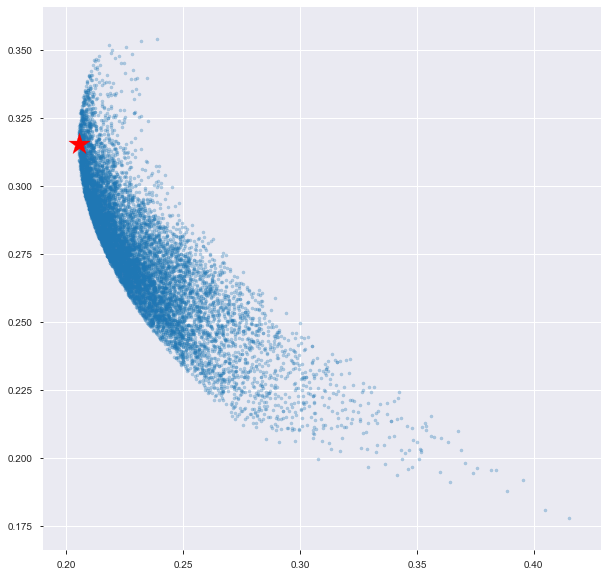

In [62]:
# plotting the minimum volatility portfolio
plt.subplots(figsize=[10,10])
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)

The red star denotes the most efficient portfolio with minimum volatility.

It is worthwhile to note that any point to the right of efficient frontier boundary is a sup-optimal portfolio.

We found the portfolio with minimum volatility, but you will notice that the return on this portfolio is pretty low. Any sensible investor wants to maximize his return, even if it is a tradeoff with some level of risk.

The question arises that how do we find this optimal risky portfolio and finally optimize our portfolio to the maximum?

This is done by using a parameter called the **Sharpe Ratio**.

### Sharpe Ratio
The ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk. Volatility is a measure of the price fluctuations of an asset or portfolio.

The risk-free rate of return is the return on an investment with zero risk, meaning it’s the return investors could expect for taking no risk.

The optimal risky portfolio is the one with the highest Sharpe ratio. The formula for this ratio is:

$ R_p $ = return of the portfolio,$ \quad R_f =$ Risk free rate, $\quad 𝜎_p =$ standard deviation of the portfolio   

Sharpe Ratio = $ \frac{R_p - R_f}{𝜎_p} $   
Below is the code for finding out portfolio with maximum Sharpe Ratio. This portfolio is the optimized portfolio that we wanted to find. We define the risk-free rate to be 1% or 0.01.

### Optimal Risky Portfolio
An optimal risky portfolio can be considered as one that has highest Sharpe ratio.

In [63]:
# Finding the optimal portfolio
rf = 0.01 # risk factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns        0.346478
Volatility     0.211869
AAPL weight    0.474041
MSFT weight    0.515592
TSLA weight    0.002323
FB weight      0.008043
Name: 4796, dtype: float64

You can notice that while the difference in risk between minimum volatility portfolio and optimal risky portfolio is just 1%, the difference in returns is 4%.
We can plot this point too on the graph of efficient frontier:
The green star represents the optimal risky portfolio.

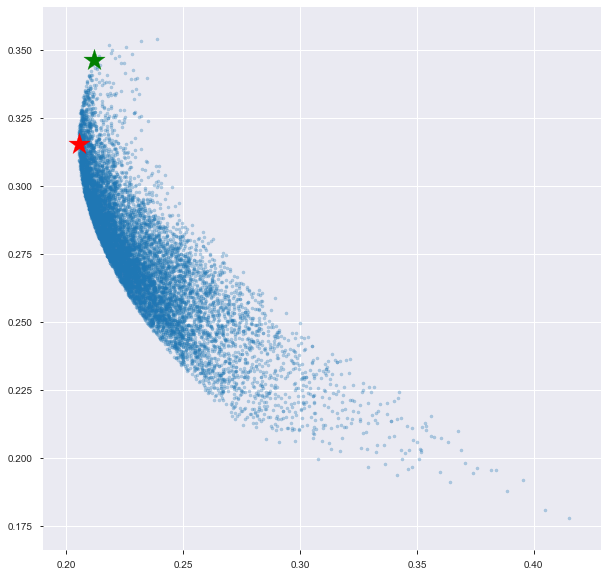

In [64]:
# Plotting optimal portfolio
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)

But how would have this portfolio actually perfomed this is something i want to expand on:

In [77]:
df_example=df_Nasdaq[l_stocks]
df_example=df_example['2020-01-01':'2021-01-04']
df_example.tail()

,AAPL,MSFT,TSLA,FB
2020-12-28,136.486053,224.443069,663.690002,277.000000
2020-12-29,134.668762,223.634918,665.989990,276.779999
2020-12-30,133.520477,221.170593,694.780029,271.869995
2020-12-31,132.492020,221.908905,705.669983,273.160004
2021-01-04,129.216919,217.189774,729.770020,268.940002


Expected Return:  0.35
Actual Return:    0.56


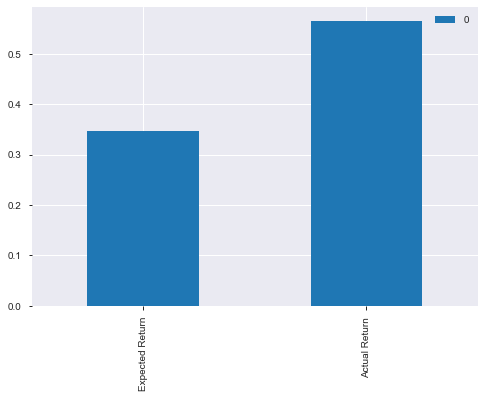

In [107]:
# Weights as advised above returns
w = [0.474041, 0.515592, 0.002323, 0.008043]

#actual log of pct change
actual_performance =df_example.pct_change().apply(lambda x: np.log(1+x)).sum()

#now we have summed we inverse the log & use the advised weights & Sum to get the portfolios performnce
port_performance=((actual_performance.apply(lambda x: math.exp(x)-1))*w).sum()

print("Expected Return: ",round(optimal_risky_port[0],2))
print("Actual Return:   ",round(port_performance,2))
pd.DataFrame([optimal_risky_port[0],((actual_performance.apply(lambda x: math.exp(x)-1))*w).sum()],index=['Expected Return','Actual Return']).plot(kind='bar')


So for 2020 our optimal portfolio based off the 2015 - 2019 data outperformed our expected returns by **21% !!!!!!!!!!!!!!**.

# Using this approach at scale:
We need to use a library thats built for this to do this at scale at speed

## To Do:
- <span style="color:green">**Add drop the last days data and reload when updating dbs**
    - DONE: now before saving the updated DB I drop the last row of incomplete data </span>
- <span style="color:green"> **DONE: Drop any columns which have nulls in the last row** </span>
- <span style="color:green"> **DONE:Add intro and example on subset of the data**</span>
- width has an effect of speed is removing negative returns a good tactic to reduce size
    - Remove any stocks with high prices (as i cant afford to buy those)
    - drop any columns which have nulls in the last row
    - Update list of active stock tickers 
        - have TSVs need to save as CSV to use
- something is breaking the pyportfolio opt i think its either size or nulls 
    - it was NULLS , solved by checking the last rows for NULL ie delisted shares
- use rolling time windows to find the best time frame to use for creating Optimised portfolios
- Create a way to check expected vs actual returns on multiple portfolios to answer What % of the time does the optimal porfolio achive the expected returns or greater and when it is under what does that look like % wise
- start & end in euros
- look at indexes

## Load data from data bases

In [9]:
%%time
df_NYSE=connectAndLoadDb('Nasdaq')
df_Nasdaq=connectAndLoadDb('NYSE')

#set dates as index
df_NYSE=df_NYSE.set_index(pd.DatetimeIndex(df_NYSE['Date'].values))
df_NYSE.drop(columns=['Date'],axis=1, inplace=True)

df_Nasdaq=df_Nasdaq.set_index(pd.DatetimeIndex(df_Nasdaq['Date'].values))
df_Nasdaq.drop(columns=['Date'],axis=1, inplace=True)

Connecting database:Nasdaq
Database connected!
Connecting database:NYSE
Database connected!
Wall time: 7.26 s


In [10]:
# Here we want to remove any Columns which have NULLs in the last row ie they are no longer listed

#we ake the last row of the df dropna to remove the null columns and keep the other columns
NYSE_lastrow=df_NYSE.tail(5)
NYSE_lastrow.dropna(axis=1, how='any',inplace=True)
len(NYSE_lastrow.columns)
#last_element = df["A"].iloc[-1]

2658

In [11]:
#For any columns that are all NA drop them 
df_NYSE=df_NYSE[NYSE_lastrow.columns]
df_Nasdaq.dropna(axis=1, how='all', inplace=True)
df_NYSE.tail()

,AAL,AAME,AAOI,AAON,AAPL,AAWW,AAXJ,AAXN,ABCB,ABEO,ABIO,ABMD,ABTX,ABUS,ACAD,ACBI,ACER,ACET,ACGL,...,YTRA,YVR,YY,Z,ZBRA,ZEAL,ZEUS,ZG,ZGNX,ZION,ZIOP,ZIXI,ZKIN,ZLAB,ZNGA,ZS,ZSAN,ZUMZ,ZYNE
2021-02-19,18.680000,4.64,12.30,77.000000,129.869995,62.230000,101.199997,177.000000,47.529999,2.41,4.75,331.970001,36.995552,4.39,51.730000,19.290001,3.58,16.120001,35.090000,...,2.67,1.95,127.360001,181.220001,490.940002,33.570000,16.252439,191.460007,22.990000,51.700001,5.16,10.13,8.72,175.360001,12.18,226.029999,1.49,46.040001,5.42
2021-02-22,20.440001,4.96,11.74,76.000000,126.000000,60.000000,98.300003,170.000000,48.349998,2.23,4.89,322.750000,37.593700,4.29,50.180000,19.740000,3.32,16.280001,35.160000,...,2.55,1.95,122.769997,169.619995,488.309998,31.910000,18.230303,173.729996,23.430000,53.360001,4.82,10.00,10.25,166.789993,11.69,213.449997,1.48,47.750000,4.91
2021-02-23,20.660000,4.41,11.40,76.830002,125.860001,57.830002,98.760002,169.139999,49.080002,2.10,4.68,321.690002,38.012405,3.83,49.740002,19.860001,3.16,15.710000,35.150002,...,2.44,1.85,123.089996,168.869995,498.019989,31.500000,18.749743,175.080002,22.879999,54.169998,4.72,9.74,9.02,161.679993,11.40,206.509995,1.26,46.779999,4.75
2021-02-24,21.820000,4.53,11.61,77.879997,125.349998,59.090000,97.660004,161.449997,50.240002,2.20,4.71,323.779999,38.789997,4.42,48.689999,20.040001,3.35,16.400000,35.570000,...,2.42,1.88,120.910004,164.279999,512.690002,31.750000,19.139320,172.220001,23.430000,56.779999,4.90,9.59,8.55,156.899994,11.29,207.809998,1.40,47.990002,5.01
2021-02-25,20.860001,4.63,11.17,76.629997,120.989998,56.070000,95.980003,159.899994,48.119999,2.49,4.39,320.470001,38.119999,3.81,47.310001,20.490000,3.17,15.750000,35.490002,...,2.32,1.78,117.830002,152.440002,497.619995,31.799999,18.510000,159.330002,22.160000,54.570000,4.65,9.26,7.40,147.389999,11.04,195.789993,1.30,46.520000,4.46


In [12]:
df_NYSE=df_NYSE#[df_NYSE.columns[0:100]]
df_NYSE.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3814 entries, 2006-01-03 to 2021-02-25
Columns: 2658 entries, AAL to ZYNE
dtypes: float64(2658)
memory usage: 77.4 MB


In [13]:
df_NYSE=df_NYSE['2015-01-02':'2021-02-24']
#df_NYSE.dropna(axis=1, how='all', inplace=True)
df_NYSE.tail()

,AAL,AAME,AAOI,AAON,AAPL,AAWW,AAXJ,AAXN,ABCB,ABEO,ABIO,ABMD,ABTX,ABUS,ACAD,ACBI,ACER,ACET,ACGL,...,YTRA,YVR,YY,Z,ZBRA,ZEAL,ZEUS,ZG,ZGNX,ZION,ZIOP,ZIXI,ZKIN,ZLAB,ZNGA,ZS,ZSAN,ZUMZ,ZYNE
2021-02-18,17.709999,5.24,11.94,75.489998,129.710007,57.040001,100.419998,173.750000,46.320000,2.46,4.66,322.079987,35.978695,4.28,50.419998,18.940001,3.50,15.800000,34.919998,...,2.63,2.02,135.529999,181.250000,477.649994,32.880001,15.033756,187.149994,22.430000,50.029999,5.07,9.95,7.77,171.470001,12.10,223.380005,1.49,45.240002,5.74
2021-02-19,18.680000,4.64,12.30,77.000000,129.869995,62.230000,101.199997,177.000000,47.529999,2.41,4.75,331.970001,36.995552,4.39,51.730000,19.290001,3.58,16.120001,35.090000,...,2.67,1.95,127.360001,181.220001,490.940002,33.570000,16.252439,191.460007,22.990000,51.700001,5.16,10.13,8.72,175.360001,12.18,226.029999,1.49,46.040001,5.42
2021-02-22,20.440001,4.96,11.74,76.000000,126.000000,60.000000,98.300003,170.000000,48.349998,2.23,4.89,322.750000,37.593700,4.29,50.180000,19.740000,3.32,16.280001,35.160000,...,2.55,1.95,122.769997,169.619995,488.309998,31.910000,18.230303,173.729996,23.430000,53.360001,4.82,10.00,10.25,166.789993,11.69,213.449997,1.48,47.750000,4.91
2021-02-23,20.660000,4.41,11.40,76.830002,125.860001,57.830002,98.760002,169.139999,49.080002,2.10,4.68,321.690002,38.012405,3.83,49.740002,19.860001,3.16,15.710000,35.150002,...,2.44,1.85,123.089996,168.869995,498.019989,31.500000,18.749743,175.080002,22.879999,54.169998,4.72,9.74,9.02,161.679993,11.40,206.509995,1.26,46.779999,4.75
2021-02-24,21.820000,4.53,11.61,77.879997,125.349998,59.090000,97.660004,161.449997,50.240002,2.20,4.71,323.779999,38.789997,4.42,48.689999,20.040001,3.35,16.400000,35.570000,...,2.42,1.88,120.910004,164.279999,512.690002,31.750000,19.139320,172.220001,23.430000,56.779999,4.90,9.59,8.55,156.899994,11.29,207.809998,1.40,47.990002,5.01


In [299]:
NYSE_assets=df_NYSE.columns

In [300]:
# Log of percentage change
cov_matrix = df_NYSE.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

,AAL,AAME,AAOI,AAON,AAPL,AAWW,AAXJ,ABCB,ABEO,ABIO,ABMD,ABTX,ABUS,ACAD,ACBI,ACER,ACET,ACGL,ACGLO,...,YTRA,YVR,YY,Z,ZBRA,ZEAL,ZEUS,ZG,ZGNX,ZION,ZIOP,ZIXI,ZKIN,ZLAB,ZNGA,ZS,ZSAN,ZUMZ,ZYNE
AAL,0.001107,0.000044,0.000266,0.000187,0.000171,0.000313,0.000170,0.000401,0.000266,-0.000058,0.000174,0.000343,0.000194,0.000191,0.000381,0.000324,0.000279,0.000246,0.000175,...,0.000355,-0.000058,0.000226,0.000246,0.000246,0.000131,3.008548e-04,0.000247,0.000274,0.000348,0.000263,0.000315,0.000205,0.000201,0.000054,0.000091,0.000269,0.000321,0.000312
AAME,0.000044,0.002128,0.000052,0.000038,0.000040,-0.000012,0.000028,0.000003,0.000114,0.000031,0.000050,0.000015,0.000093,0.000003,0.000020,-0.000056,-0.000147,0.000023,0.000013,...,0.000118,0.000115,0.000049,0.000080,0.000007,0.000205,-4.020423e-07,0.000056,0.000082,0.000006,0.000200,0.000130,-0.000070,0.000069,0.000089,0.000038,0.000210,0.000029,0.000133
AAOI,0.000266,0.000052,0.001985,0.000199,0.000215,0.000270,0.000170,0.000243,0.000396,0.000153,0.000218,0.000208,0.000313,0.000266,0.000206,0.000328,0.000357,0.000148,0.000081,...,0.000296,-0.000057,0.000281,0.000339,0.000294,0.000259,2.851933e-04,0.000327,0.000339,0.000219,0.000404,0.000332,0.000164,0.000311,0.000197,0.000347,0.000358,0.000245,0.000201
AAON,0.000187,0.000038,0.000199,0.000453,0.000143,0.000239,0.000107,0.000221,0.000158,0.000062,0.000130,0.000202,0.000173,0.000171,0.000182,0.000181,0.000221,0.000139,0.000056,...,0.000093,0.000013,0.000126,0.000157,0.000185,0.000137,2.260113e-04,0.000151,0.000164,0.000190,0.000212,0.000181,0.000079,0.000162,0.000102,0.000176,0.000153,0.000170,0.000168
AAPL,0.000171,0.000040,0.000215,0.000143,0.000349,0.000176,0.000146,0.000143,0.000202,0.000099,0.000173,0.000140,0.000166,0.000197,0.000126,0.000240,0.000192,0.000130,0.000069,...,0.000173,-0.000004,0.000186,0.000209,0.000220,0.000181,1.288993e-04,0.000203,0.000178,0.000128,0.000212,0.000160,0.000089,0.000233,0.000135,0.000270,0.000159,0.000098,0.000172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNGA,0.000054,0.000089,0.000197,0.000102,0.000135,0.000133,0.000094,0.000074,0.000191,0.000037,0.000143,0.000063,0.000152,0.000205,0.000067,0.000120,0.000226,0.000069,0.000040,...,0.000083,0.000052,0.000159,0.000188,0.000151,0.000138,8.810291e-05,0.000173,0.000159,0.000058,0.000205,0.000132,0.000084,0.000191,0.000512,0.000377,0.000134,0.000042,0.000191
ZS,0.000091,0.000038,0.000347,0.000176,0.000270,0.000304,0.000166,0.000049,0.000403,-0.000008,0.000274,0.000020,0.000392,0.000350,0.000004,0.000218,0.000317,0.000078,0.000040,...,0.000109,0.000255,0.000356,0.000358,0.000324,0.000274,9.821312e-05,0.000362,0.000234,0.000010,0.000292,0.000225,0.000098,0.000294,0.000377,0.001516,0.000173,0.000021,0.000271
ZSAN,0.000269,0.000210,0.000358,0.000153,0.000159,0.000114,0.000108,0.000231,0.000608,-0.000218,0.000273,0.000208,0.000410,0.000252,0.000182,0.000384,0.000591,0.000144,0.000085,...,0.000314,0.000242,0.000118,0.000127,0.000168,0.000329,2.317428e-04,0.000118,0.000448,0.000190,0.000542,0.000271,0.000492,0.000179,0.000134,0.000173,0.006038,0.000137,0.000347
ZUMZ,0.000321,0.000029,0.000245,0.000170,0.000098,0.000189,0.000099,0.000294,0.000220,0.000089,0.000129,0.000253,0.000251,0.000176,0.000245,0.000241,0.000291,0.000165,0.000064,...,0.000252,0.000014,0.000064,0.000185,0.000185,0.000067,2.703061e-04,0.000175,0.000200,0.000258,0.000223,0.000209,0.000048,0.000152,0.000042,0.000021,0.000137,0.001102,0.000244


In [301]:
corr_matrix = df_NYSE.pct_change().apply(lambda x: np.log(1+x)).corr()
corr_matrix

,AAL,AAME,AAOI,AAON,AAPL,AAWW,AAXJ,ABCB,ABEO,ABIO,ABMD,ABTX,ABUS,ACAD,ACBI,ACER,ACET,ACGL,ACGLO,...,YTRA,YVR,YY,Z,ZBRA,ZEAL,ZEUS,ZG,ZGNX,ZION,ZIOP,ZIXI,ZKIN,ZLAB,ZNGA,ZS,ZSAN,ZUMZ,ZYNE
AAL,1.000000,0.028749,0.179295,0.264287,0.275653,0.311566,0.392551,0.498158,0.128961,-0.022738,0.177761,0.417895,0.097909,0.142839,0.452862,0.119995,0.074547,0.418845,0.369492,...,0.229484,-0.028118,0.203220,0.219125,0.286549,0.090923,0.238877,0.227910,0.177857,0.476420,0.167229,0.292197,0.097847,0.146760,0.072332,0.055327,0.103984,0.290653,0.136935
AAME,0.028749,1.000000,0.025104,0.039145,0.046254,-0.008330,0.047558,0.002989,0.039880,0.008791,0.036493,0.012767,0.033868,0.001380,0.016540,-0.014939,-0.028167,0.028091,0.018752,...,0.053732,0.040465,0.031630,0.050273,0.006285,0.100230,-0.000230,0.037007,0.038301,0.006015,0.091749,0.086657,-0.023743,0.035717,0.085696,0.016376,0.058370,0.018679,0.041329
AAOI,0.179295,0.025104,1.000000,0.210287,0.258845,0.200825,0.294410,0.225988,0.143536,0.044962,0.165973,0.190970,0.118038,0.148743,0.184367,0.090577,0.089516,0.188316,0.155080,...,0.151633,-0.020800,0.189033,0.225707,0.256296,0.161385,0.169099,0.225334,0.164650,0.224079,0.191920,0.229533,0.070800,0.205804,0.195389,0.202681,0.103105,0.165698,0.066077
AAON,0.264287,0.039145,0.210287,1.000000,0.359638,0.372489,0.388596,0.428685,0.120052,0.038009,0.207347,0.388178,0.136768,0.200416,0.342257,0.104681,0.100718,0.370852,0.202102,...,0.099097,0.009553,0.177312,0.219069,0.336686,0.160502,0.280440,0.217270,0.166224,0.405697,0.210535,0.262707,0.063858,0.200161,0.211429,0.184151,0.092212,0.240392,0.115261
AAPL,0.275653,0.046254,0.258845,0.359638,1.000000,0.312444,0.601019,0.316494,0.174683,0.069323,0.314890,0.310466,0.149290,0.263191,0.271979,0.158143,0.096155,0.394292,0.272995,...,0.208303,-0.003306,0.297350,0.332335,0.456384,0.234379,0.182192,0.333494,0.205618,0.310814,0.240114,0.264748,0.079969,0.318860,0.318263,0.309878,0.109387,0.158392,0.135164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNGA,0.072332,0.085696,0.195389,0.211429,0.318263,0.194632,0.318600,0.135136,0.136000,0.021479,0.214281,0.119334,0.113044,0.226113,0.124352,0.065006,0.111717,0.173508,0.153818,...,0.092639,0.037410,0.210079,0.259430,0.258373,0.172466,0.102842,0.234944,0.151600,0.115978,0.191743,0.180450,0.072803,0.252183,1.000000,0.430584,0.076126,0.055551,0.130201
ZS,0.055327,0.016376,0.202681,0.184151,0.309878,0.218798,0.287337,0.040571,0.154476,-0.002368,0.226008,0.019870,0.132945,0.209021,0.003440,0.068775,0.088719,0.085906,0.079133,...,0.058556,0.102825,0.249211,0.234026,0.310315,0.184557,0.069941,0.234771,0.162624,0.009668,0.153253,0.142892,0.046244,0.221624,0.430584,1.000000,0.052113,0.016171,0.117013
ZSAN,0.103984,0.058370,0.103105,0.092212,0.109387,0.048605,0.106621,0.123139,0.125918,-0.036590,0.119315,0.107637,0.089886,0.080629,0.091914,0.060626,0.071972,0.104091,0.081017,...,0.088266,0.050382,0.045311,0.047685,0.083378,0.102375,0.079011,0.046846,0.124428,0.111511,0.152554,0.107202,0.105717,0.058945,0.076126,0.052113,1.000000,0.053119,0.064344
ZUMZ,0.290653,0.018679,0.165698,0.240392,0.158392,0.188655,0.229721,0.366593,0.106853,0.035173,0.132022,0.329651,0.127055,0.132378,0.311169,0.089378,0.098256,0.281040,0.160080,...,0.183730,0.007050,0.057761,0.165245,0.216319,0.054939,0.215047,0.161783,0.130220,0.354434,0.141840,0.193885,0.027477,0.135942,0.055551,0.016171,0.053119,1.000000,0.107958


In [302]:
# Randomly weighted portfolio's variance
import random
NYSE_cols= df_NYSE.columns
row_count = len(NYSE_cols)
my_list = np.array([random.random() for i in range(row_count)])
# need to narmalise these weights to sum to 1:
mean=my_list.sum()
normalisedlist=my_list/mean
#create a dictionary of weights 
w = {NYSE_cols[i]: normalisedlist[i] for i in range(len(NYSE_cols))}

port_var = cov_matrix.mul(w, axis=0).mul(w, axis=1).sum().sum()
port_var

0.00016626492395209537

In [303]:
# Yearly returns for individual companies
ind_er = df_NYSE.resample('Y').last().pct_change().mean()
ind_er

AAL    -0.049715
AAME    0.073389
AAOI    0.039662
AAON    0.243660
AAPL    0.369048
          ...   
ZNGA    0.301957
ZS      1.173773
ZSAN   -0.177857
ZUMZ    0.248357
ZYNE    0.114445
Length: 2654, dtype: float64

In [304]:
# Portfolio returns
port_er = (normalisedlist*ind_er).sum()
port_er

0.19323664027068962

In [305]:
# Volatility is given by the annual standard deviation. We multiply by 250 because there are 250 trading days/year.
ann_sd = df_NYSE.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
ann_sd

AAL     0.525995
AAME    0.729318
AAOI    0.704365
AAON    0.336580
AAPL    0.295474
          ...   
ZNGA    0.357782
ZS      0.615563
ZSAN    1.228578
ZUMZ    0.524953
ZYNE    1.058734
Length: 2654, dtype: float64

In [306]:
assets = pd.concat([ind_er, ann_sd], axis=1) # Creating a table for visualising returns and volatility of assets
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
AAL,-0.049715,0.525995
AAME,0.073389,0.729318
AAOI,0.039662,0.704365
AAON,0.243660,0.336580
AAPL,0.369048,0.295474
...,...,...
ZNGA,0.301957,0.357782
ZS,1.173773,0.615563
ZSAN,-0.177857,1.228578
ZUMZ,0.248357,0.524953


In [307]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

num_assets = len(df_NYSE.columns)
#for NYSE it takes 5min 45secs per 1000 runs
num_portfolios = 10
print(num_assets)

2654


In [308]:
%%time
def yourfunction():   
    p_ret = [] # Define an empty array for portfolio returns
    p_vol = [] # Define an empty array for portfolio volatility
    p_weights = []  # Define an empty array for asset weights
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = (weights*ind_er).sum() # Returns are the product of individual expected returns of asset and its 
    #returns = np.dot(weights, ind_er)  #Old code                                # weights 
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)
    return [p_ret, p_vol, p_weights]


output = Parallel(n_jobs=-1)(delayed(yourfunction)() for portfolio in range(num_portfolios))


Wall time: 3.81 s


In [309]:
#Extract data from the list & flatten where required
p_ret=[t[0] for t in output]
p_ret=reduce(operator.concat,p_ret)
p_vol=[t[1] for t in output]
p_vol=reduce(operator.concat,p_vol)
p_weights=[t[2] for t in output]
p_weights=reduce(operator.concat,p_weights)

In [310]:
max_weights=reduce(operator.concat,p_weights)
max_weights.max()

0.0059145985181845405

# Unparrelel version for reference
%%time
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = (weights*ind_er).sum() # Returns are the product of individual expected returns of asset and its 
    #returns = np.dot(weights, ind_er)  #Old code                                # weights 
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)

In [311]:
%%time
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(df_NYSE.columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]
    
portfolios  = pd.DataFrame(data)

portfolios.head() # Dataframe of the 10000 portfolios created

Wall time: 168 ms


,Returns,Volatility,AAL weight,AAME weight,AAOI weight,AAON weight,AAPL weight,AAWW weight,AAXJ weight,ABCB weight,ABEO weight,ABIO weight,ABMD weight,ABTX weight,ABUS weight,ACAD weight,ACBI weight,ACER weight,ACET weight,...,YTRA weight,YVR weight,YY weight,Z weight,ZBRA weight,ZEAL weight,ZEUS weight,ZG weight,ZGNX weight,ZION weight,ZIOP weight,ZIXI weight,ZKIN weight,ZLAB weight,ZNGA weight,ZS weight,ZSAN weight,ZUMZ weight,ZYNE weight
0,0.198096,0.204850,0.000264,0.000570,0.000105,0.000262,0.000093,0.000440,0.000313,0.000211,0.000685,0.000092,0.000407,0.000419,0.000060,0.000688,0.000084,0.000532,0.000222,...,0.000188,0.000276,0.000312,0.000633,0.000736,0.000349,0.000735,0.000475,0.000103,0.000350,0.000458,0.000038,0.000198,0.000334,0.000390,0.000438,0.000521,0.000015,0.000611
1,0.195586,0.203710,0.000263,0.000222,0.000386,0.000394,0.000042,0.000382,0.000314,0.000629,0.000621,0.000214,0.000158,0.000276,0.000047,0.000548,0.000752,0.000625,0.000150,...,0.000558,0.000750,0.000083,0.000353,0.000057,0.000194,0.000684,0.000601,0.000412,0.000248,0.000046,0.000679,0.000360,0.000605,0.000754,0.000512,0.000112,0.000065,0.000468
2,0.199348,0.204547,0.000143,0.000126,0.000034,0.000732,0.000491,0.000139,0.000201,0.000310,0.000236,0.000022,0.000282,0.000694,0.000474,0.000067,0.000031,0.000713,0.000200,...,0.000484,0.000425,0.000693,0.000208,0.000502,0.000381,0.000444,0.000496,0.000122,0.000372,0.000616,0.000342,0.000476,0.000477,0.000232,0.000036,0.000209,0.000145,0.000071
3,0.194932,0.202102,0.000385,0.000164,0.000635,0.000178,0.000414,0.000154,0.000410,0.000087,0.000333,0.000688,0.000561,0.000148,0.000685,0.000206,0.000253,0.000350,0.000061,...,0.000696,0.000575,0.000698,0.000325,0.000611,0.000066,0.000613,0.000498,0.000664,0.000626,0.000663,0.000093,0.000684,0.000360,0.000731,0.000556,0.000088,0.000160,0.000517
4,0.192360,0.201831,0.000505,0.000279,0.000184,0.000102,0.000680,0.000356,0.000151,0.000656,0.000466,0.000658,0.000747,0.000680,0.000436,0.000193,0.000090,0.000548,0.000637,...,0.000229,0.000050,0.000494,0.000185,0.000736,0.000589,0.000574,0.000703,0.000551,0.000239,0.000707,0.000551,0.000669,0.000679,0.000470,0.000169,0.000282,0.000417,0.000534


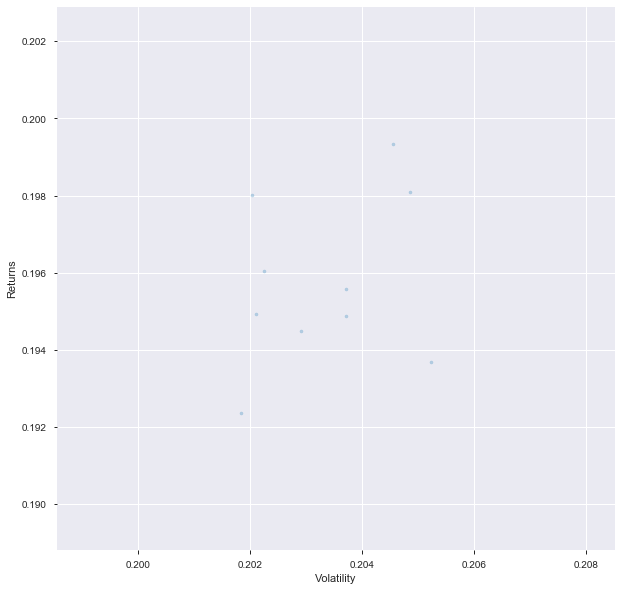

In [312]:
# Plot efficient frontier
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])

In [313]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.                               
min_vol_port

Returns        0.192360
Volatility     0.201831
AAL weight     0.000505
AAME weight    0.000279
AAOI weight    0.000184
                 ...   
ZNGA weight    0.000470
ZS weight      0.000169
ZSAN weight    0.000282
ZUMZ weight    0.000417
ZYNE weight    0.000534
Name: 4, Length: 2656, dtype: float64

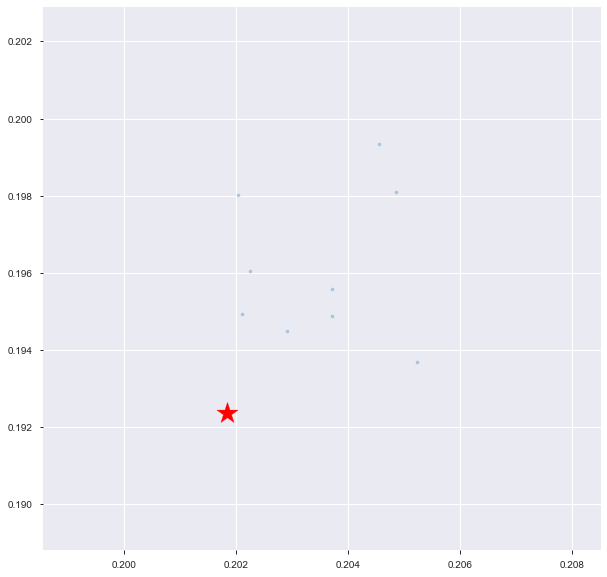

In [314]:
# plotting the minimum volatility portfolio
plt.subplots(figsize=[10,10])
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)

In [315]:
# Finding the optimal portfolio
rf = 0.01 # risk factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns        0.198028
Volatility     0.202028
AAL weight     0.000272
AAME weight    0.000739
AAOI weight    0.000426
                 ...   
ZNGA weight    0.000588
ZS weight      0.000279
ZSAN weight    0.000651
ZUMZ weight    0.000285
ZYNE weight    0.000240
Name: 7, Length: 2656, dtype: float64

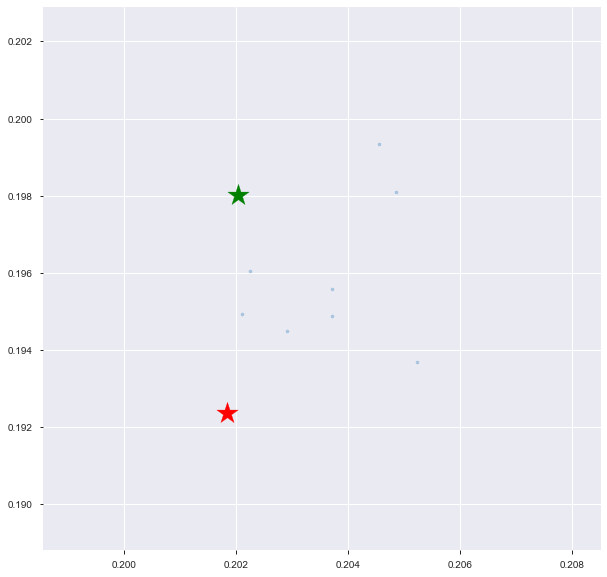

In [316]:
# Plotting optimal portfolio
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)

# Trying the youtube methods

In [14]:
%%time
#Calculate expected annulised returns & annual sample covariance matrix of the daily asset
NYSE_mu = expected_returns.mean_historical_return(df_NYSE)
NYSE_S = risk_models.sample_cov(df_NYSE)
NYSE_S

C:\Users\patri\AppData\Local\Continuum\anaconda3\lib\site-packages\pypfopt\risk_models.py:69: UserWarning:

The covariance matrix is non positive semidefinite. Amending eigenvalues.



Wall time: 31 s


C:\Users\patri\AppData\Local\Continuum\anaconda3\lib\site-packages\pypfopt\risk_models.py:88: UserWarning:

Could not fix matrix. Please try a different risk model.



,AAL,AAME,AAOI,AAON,AAPL,AAWW,AAXJ,AAXN,ABCB,ABEO,ABIO,ABMD,ABTX,ABUS,ACAD,ACBI,ACER,ACET,ACGL,...,YTRA,YVR,YY,Z,ZBRA,ZEAL,ZEUS,ZG,ZGNX,ZION,ZIOP,ZIXI,ZKIN,ZLAB,ZNGA,ZS,ZSAN,ZUMZ,ZYNE
AAL,0.321547,-0.009746,0.073507,0.047292,0.043569,0.069309,0.041050,0.053618,0.103407,0.064978,-0.049227,0.041728,0.087427,0.049122,0.044451,0.091007,0.074681,0.070360,0.058243,...,0.078459,-0.035427,0.066522,0.049502,0.060195,0.032400,0.076091,0.050974,0.065325,0.090050,0.087350,0.072169,0.044991,0.046138,0.001192,0.027242,0.081898,0.080899,0.101987
AAME,-0.009746,0.878912,0.006708,0.007197,0.009961,0.002709,0.009918,0.010979,0.005513,0.044926,-0.004232,0.024410,0.000177,0.024054,-0.004898,0.007841,-0.005051,-0.006808,0.014038,...,0.032243,0.064603,0.005732,0.045809,0.002868,0.054295,0.003915,0.031050,0.028195,-0.001188,0.032619,0.055601,-0.014583,0.021327,0.041684,0.004479,0.101143,0.011037,0.035541
AAOI,0.073507,0.006708,0.515386,0.052593,0.052948,0.067599,0.041467,0.046569,0.060494,0.095404,0.022640,0.051818,0.051726,0.083342,0.069205,0.050323,0.083517,0.091095,0.033105,...,0.065946,-0.026632,0.076864,0.083766,0.073563,0.063400,0.071494,0.082108,0.082245,0.053831,0.114619,0.081260,0.038327,0.072967,0.045353,0.082937,0.092806,0.060381,0.051939
AAON,0.047292,0.007197,0.052593,0.126060,0.036562,0.060187,0.026765,0.039461,0.054238,0.035276,0.007185,0.033464,0.050474,0.042065,0.044565,0.045663,0.041904,0.054981,0.034047,...,0.025003,0.001838,0.029720,0.038375,0.048173,0.033223,0.055875,0.036955,0.040047,0.048179,0.055207,0.045583,0.020795,0.041014,0.023980,0.042628,0.042818,0.042892,0.047550
AAPL,0.043569,0.009961,0.052948,0.036562,0.095135,0.045264,0.037173,0.048964,0.036740,0.048861,0.027804,0.045415,0.034983,0.036354,0.048863,0.031620,0.060720,0.049090,0.033613,...,0.039305,0.001628,0.046729,0.052216,0.055243,0.042172,0.032523,0.051940,0.044637,0.031404,0.052487,0.042276,0.020502,0.055262,0.034428,0.065016,0.039782,0.024717,0.043041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNGA,0.001192,0.041684,0.045353,0.023980,0.034428,0.040995,0.024340,0.041068,0.018287,0.045834,0.013455,0.038003,0.014321,0.035048,0.052724,0.017048,0.027042,0.045650,0.020346,...,0.022843,0.025526,0.031817,0.056090,0.040588,0.033211,0.019684,0.052363,0.042912,0.011561,0.035374,0.038782,0.027980,0.049079,0.148367,0.090263,0.030063,0.011781,0.020697
ZS,0.027242,0.004479,0.082937,0.042628,0.065016,0.072375,0.040638,0.083407,0.009701,0.090168,0.004869,0.065849,0.005921,0.085953,0.084173,-0.000846,0.039619,0.098215,0.016503,...,0.028183,0.054394,0.085874,0.080207,0.077203,0.077225,0.025123,0.079039,0.061434,0.003355,0.073131,0.050338,0.031216,0.088990,0.090263,0.476587,0.038410,0.004282,0.071351
ZSAN,0.081898,0.101143,0.092806,0.042818,0.039782,0.021022,0.027148,0.032343,0.062457,0.207003,-0.044185,0.061004,0.055703,0.134903,0.052717,0.045295,0.108775,0.145873,0.035559,...,0.091232,0.054668,0.038617,0.022592,0.037517,0.080899,0.046722,0.021755,0.116685,0.048594,0.163779,0.074942,0.142688,0.051513,0.030063,0.038410,1.968603,0.037839,0.155001
ZUMZ,0.080899,0.011037,0.060381,0.042892,0.024717,0.048134,0.025111,0.050720,0.077952,0.056517,0.015545,0.033414,0.065028,0.070464,0.047104,0.063997,0.062142,0.068184,0.043609,...,0.063488,0.008371,0.015280,0.051312,0.047497,0.015234,0.069125,0.048774,0.053973,0.067171,0.055947,0.055658,0.009322,0.036482,0.011781,0.004282,0.037839,0.287156,0.054345


In [15]:
%%time
# Optomise for maximal Sharpe ratio
NYSE_ef= EfficientFrontier(NYSE_mu, NYSE_S) #Create the Efficient Frontier Object
NYSE_weights = NYSE_ef.max_sharpe()
NYSE_cl_weights= NYSE_ef.clean_weights()
#print(NYSE_cl_weights)
NYSE_ef.portfolio_performance()

Wall time: 14.1 s


(86981.619562872, 2.0149108860111777, 43168.956089698484)

In [ ]:
# Get the discrete allocation of each share per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

portfolio_val = 1000
latest_prices=get_latest_prices(df_NYSE)
weights=NYSE_cl_weights
da=DiscreteAllocation(weights,latest_prices,total_portfolio_value=portfolio_val)
allocation, leftover = da.lp_portfolio()

print('Discrete allocation  :', allocation)
print('Funds Remaining:', leftover)